# TreeRegressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection   import RandomizedSearchCV
import joblib

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [3]:
# Split features/target
X_train = train.drop('Score', axis=1)
y_train = train['Score']
X_test  = test.drop('Score', axis=1)
y_test  = test['Score']

In [4]:
preprocessor = joblib.load("preprocessor_unfitted.joblib")

## Pipeline and RandomizedSearchCV

In [5]:
#  Wrap in a tree pipeline
tree_pipe = Pipeline([
    ("prep",  preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

In [6]:
#  Hyperparameter search space
param_dist = {
    "model__max_depth":        [None] + list(range(2, 21)),       # None or depths 2–20
    "model__min_samples_split": np.arange(2, 21),                # 2–20
    "model__min_samples_leaf":  np.arange(1, 21),                # 1–20
    "model__max_features":      [None, "sqrt", "log2"]           # features subset strategies
}

In [7]:
# RandomizedSearchCV setup
search = RandomizedSearchCV(
    estimator          = tree_pipe,
    param_distributions= param_dist,
    n_iter             = 50,                # number of random combos
    cv                 = 5,                 # 5-fold CV
    scoring            = "neg_mean_squared_error",
    n_jobs             = -1,
    random_state       = 42,
    verbose            = 1
)

print("Starting RandomizedSearch for DecisionTreeRegressor…")
search.fit(X_train, y_train)

Starting RandomizedSearch for DecisionTreeRegressor…
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['WhiteElo',
                                                                                'EloDif']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Opening_name',
 

In [8]:
# Report best parameters & CV score
best_params = search.best_params_
best_cv_mse = -search.best_score_
print("\nBest parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MSE: {best_cv_mse:.4f}")
best_tree = search.best_estimator_


Best parameters:
  model__min_samples_split: 5
  model__min_samples_leaf: 8
  model__max_features: None
  model__max_depth: 4
Best CV MSE: 0.2264


In [9]:
# Final evaluation on test set
y_pred = best_tree.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2  = r2_score(y_test, y_pred)
print(f"\nTest   MSE: {test_mse:.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test   R² : {test_r2:.4f}")



Test   MSE: 0.2273
Test MAE: 0.4579
Test   R² : 0.0349


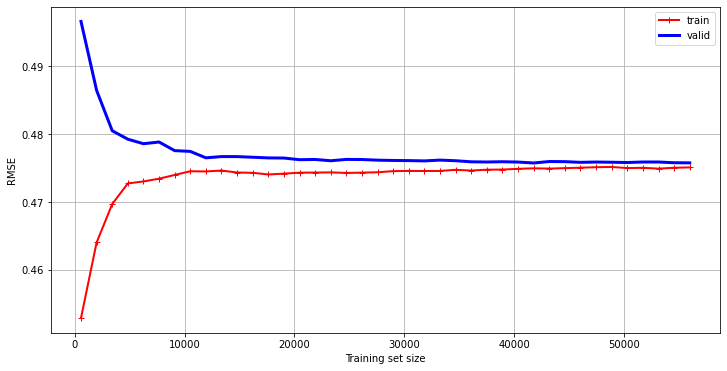

In [10]:
# Plot the learning curve for the DecisionTreeRegressor
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_tree,
                                                         X_train, y_train,
                                                         train_sizes = np.linspace(0.01, 1.0, 40),
                                                         cv = 5,
                                                         scoring = "neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

fig = plt.figure(figsize = (12, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [11]:
joblib.dump(best_tree, "best_tree.joblib")

['best_tree.joblib']